# RADICAL Analytics with an OSG Experiment

This notebook illustrates the analysis of an experiment performed with RADICAL-Pilot and OSG. The experiments use 4 1-core pilots and between 8 and 64 compute units (CU). RADICAL-Anlytics is used to acquire two data sets produced by RADICAL Pilot and then to derive aggregated and per-entity performance measures. 

Aggregated measures:

* Total time to completion (TTC); 
* Total time spent by the pilots in the OSG queue (TTQ);  
* Total time spent by the CU executing their kernel (TTX).

Single-entity performance measures are derived for each pilot and CU:

* Pilot queueing time (Tq);
* CU kernel execution time (Tx).

The profiles and json files for the runs can be found in `examples/data/` in the RADICAL-Analytics github repository. Runs are grouped in experiments. Each experiment consists of a set of continous runs: as soon as a run finished another is stated. Experiments are separated by a certain amount of time.

## Setup

Display matplotlib diagrams without having to use `plt.show()`.

In [152]:
%matplotlib inline

Load all the Python modules we will use for the analysis. Note that both RADICAL Utils and RADICAL Pilot need to be loaded alongside RADICAL Analytics.

In [153]:
import os
import sys
import glob
import pprint

import numpy as np
import scipy as sp
import scipy.stats as sps
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

## Load data sets

Acquire the execution data for each entity of the run and construct a ra.session object. We define a function to do it as we will want to create multiple sessions for multiple runs.

In [276]:
def load_data(rdir):
    sessions = {}
    start = rdir.rfind(os.sep)+1
    for path, dirs, files in os.walk(rdir):
        folders = path[start:].split(os.sep)
        if len(path[start:].split(os.sep)) == 2:
            exp = folders[0]
            run = folders[1]
            if exp not in sessions.keys():
                sessions[exp] = {}
            fjson = ru.read_json(glob.glob('%s/*.json' % path)[0])
            sid = os.path.basename(glob.glob('%s/*.json' % path)[0])[:-5]
            sessions[exp][run] = ra.Session(sid, 'radical.pilot', src=path)
    return sessions

We construct a sesion for each run we have and we store all the sessions in a dictionary (ignore the WARNINGS).

In [278]:
rdir = '../data/'
sessions = load_data(rdir)

unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced hosts: ['radical:144.76.72.175']
unsynced profile ../data/exp2/rp.session.radical.mturilli.017050.0000/pilot.0000/bootstrap_1.prof
unsynced profile ../data/exp2/rp.session.radical.mturilli.017050.0000/pilot.0001/bootstrap_1.prof
unsynced profile ../data/exp2/rp.session.radical.mturilli.017050.0000/pilot.0002/bootstrap_1.prof
unsynced profile ../data/exp2/rp.session.radical.mturilli.017050.0000/pilot.0003/bootstrap_1.prof
empty profile ../dat

We define a set of durations we want to measure and their semantics. Each
duration has two and only two timestamps, the first always preceding in
time the second. Each timestamp represents an event, in this case to a
state transition.

Our choice of the durations depends on the design of the experiment for
which we are collecting data. In this case, we want to measure the
overall time to completion (TTC) of the run and isolate two of its
components: the amoung of time spent in the queue waiting for the pilots
to become available and the amount of time spent to execute each unit.

We need to define the start and end event for these three durations and,
as such, we need to choose the entity or entities that are relevant to
our measurment. The first step is therefore to look at what entities were
recorded in the data of the run, and at what was their state model.

As seen in example 02, we look at the list of entities recorded in the
run:

In [308]:
for exp in sessions.keys():
    print exp
    for sid in sessions[exp].keys():
        
        et = sessions[exp][sid].list(['etype'])
        
        print "\t%s:\n\t%s" % (sid, et)

exp2
	rp.session.radical.mturilli.017050.0000:
	[['umgr', 'pmgr', 'agent_1', 'update', 'agent', 'agent_0', 'session', 'root', 'unit', 'pilot']]
	rp.session.radical.mturilli.017052.0008:
	[['umgr', 'pmgr', 'agent_1', 'agent_0', 'agent', 'update', 'session', 'root', 'unit', 'pilot']]
	rp.session.radical.mturilli.017053.0002:
	[['umgr', 'pmgr', 'agent_1', 'update', 'agent', 'agent_0', 'session', 'root', 'unit', 'pilot']]
	rp.session.radical.mturilli.017052.0003:
	[['umgr', 'pmgr', 'agent_1', 'agent_0', 'agent', 'update', 'session', 'root', 'unit', 'pilot']]
	rp.session.radical.mturilli.017052.0006:
	[['umgr', 'pmgr', 'agent_1', 'update', 'agent', 'agent_0', 'session', 'root', 'unit', 'pilot']]
	rp.session.radical.mturilli.017052.0007:
	[['umgr', 'pmgr', 'agent_1', 'agent_0', 'agent', 'update', 'session', 'root', 'unit', 'pilot']]
	rp.session.radical.mturilli.017052.0005:
	[['umgr', 'pmgr', 'agent_1', 'update', 'agent', 'agent_0', 'session', 'root', 'unit', 'pilot']]
	rp.session.radical.mt

And we choose 'session', 'pilot', and 'unit'. We do not care 'umgr',
'pmgr', 'update' as we care only about the overall duration of the run
(for which we use the satates of session) and measuring aggregates
durations for pilots and units, not for the RP managers.

We look at the states of the entity 'session' (TO BE IMPLEMENTED):

In [311]:
for exp in sessions.keys():
    print '\n'+exp
    for sid in sessions[exp].keys():
        
        sm = sessions[exp][sid].describe('state_model', etype=['session'])
        
        print "\t%s: %s" % (sid, sm)


exp2
	rp.session.radical.mturilli.017050.0000: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017052.0008: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017053.0002: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017052.0003: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017052.0006: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017052.0007: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017052.0005: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017053.0001: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017053.0000: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017051.0008: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017051.0007: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017051.0006: {'session': {'state_model': {}}}
	rp.session.radical.mturilli.017051.0005: {'session': {'state_model': {}}}
	rp.session.radical

We look at the states of the entity 'pilot' for one of the session we have. We know all the sessions are the same so we can avoid to inspect all of them:

In [312]:
for exp in sessions.keys():
    print '\n'+exp
    for sid in sessions[exp].keys():
        print '\n'+sid
        
        sv = sessions[exp][sid].describe('state_values', etype=['pilot'])
        
        pprint.pprint(sv.values()[0].values()[0])


exp2

rp.session.radical.mturilli.017050.0000
{-1: None,
 0: 'NEW',
 1: 'LAUNCHING_PENDING',
 2: 'LAUNCHING',
 3: 'ACTIVE_PENDING',
 4: 'ACTIVE',
 5: ['FAILED', 'DONE', 'CANCELED']}

rp.session.radical.mturilli.017052.0008
{-1: None,
 0: 'NEW',
 1: 'LAUNCHING_PENDING',
 2: 'LAUNCHING',
 3: 'ACTIVE_PENDING',
 4: 'ACTIVE',
 5: ['FAILED', 'DONE', 'CANCELED']}

rp.session.radical.mturilli.017053.0002
{-1: None,
 0: 'NEW',
 1: 'LAUNCHING_PENDING',
 2: 'LAUNCHING',
 3: 'ACTIVE_PENDING',
 4: 'ACTIVE',
 5: ['FAILED', 'DONE', 'CANCELED']}

rp.session.radical.mturilli.017052.0003
{-1: None,
 0: 'NEW',
 1: 'LAUNCHING_PENDING',
 2: 'LAUNCHING',
 3: 'ACTIVE_PENDING',
 4: 'ACTIVE',
 5: ['FAILED', 'DONE', 'CANCELED']}

rp.session.radical.mturilli.017052.0006
{-1: None,
 0: 'NEW',
 1: 'LAUNCHING_PENDING',
 2: 'LAUNCHING',
 3: 'ACTIVE_PENDING',
 4: 'ACTIVE',
 5: ['FAILED', 'DONE', 'CANCELED']}

rp.session.radical.mturilli.017052.0007
{-1: None,
 0: 'NEW',
 1: 'LAUNCHING_PENDING',
 2: 'LAUNCHING',
 3: 

From the RADICAL-Pilot documentation and state model description, we know that a pilot is described, it is assigned to a pmgr, and scheduled on its target resource queue. We use 'LAUNCHING_PENDING' as the event indicating that a pilot has been queued, and LAUNCHING' and the indication that a pilot has been scheduled on the compute nodes by the resource's batch system (e.g., PBS). We indicate queue time with Tq and measure it for each pilot as:

Tq = PMGR_LAUNCHING - PMGR_LAUNCHING_PENDING

We should note that in presence of multiple pilots, the queue time of one or more pilot can overlap, partially overlap, or not overlap. When calculating the total amount of queue time for the whole run, we need to account fo overlappings and therefore for time subtractions or addition. Luckily, the method session.duration does all this for us.

As seen in example 04:

In [315]:
pilots = {}
TTQs = {}

for exp in sessions.keys():
    print '\n'+exp
    for sid in sessions[exp].keys():

        pilots[sid] = sessions[exp][sid].filter(etype='pilot', inplace=False)
        TTQs[sid] = pilots[sid].duration(['PMGR_LAUNCHING_PENDING', 'PMGR_LAUNCHING'])

        print "\t%s: TTQ = %s" % (sid, TTQs[sid])


exp2
	rp.session.radical.mturilli.017050.0000: TTQ = 0.00189995765686
	rp.session.radical.mturilli.017052.0008: TTQ = 0.0019998550415
	rp.session.radical.mturilli.017053.0002: TTQ = 0.00230002403259
	rp.session.radical.mturilli.017052.0003: TTQ = 0.00200009346008
	rp.session.radical.mturilli.017052.0006: TTQ = 0.00189995765686
	rp.session.radical.mturilli.017052.0007: TTQ = 0.00230002403259
	rp.session.radical.mturilli.017052.0005: TTQ = 0.00179982185364
	rp.session.radical.mturilli.017053.0001: TTQ = 0.00209999084473
	rp.session.radical.mturilli.017053.0000: TTQ = 0.00219988822937
	rp.session.radical.mturilli.017051.0008: TTQ = 0.00209999084473
	rp.session.radical.mturilli.017051.0007: TTQ = 0.00229978561401
	rp.session.radical.mturilli.017051.0006: TTQ = 0.00209999084473
	rp.session.radical.mturilli.017051.0005: TTQ = 0.00220012664795
	rp.session.radical.mturilli.017051.0004: TTQ = 0.00180006027222
	rp.session.radical.mturilli.017051.0003: TTQ = 0.00189995765686
	rp.session.radical.

We measure also Tq for each pilot indipendently. Depending on their overlapping, the overall Tq might be the a value between the sum of 4 indipendent Tq or the value of the longest Tq.

We print also their state models so to check how they performed after leaving the queue. This will give an insight for when we will look at the portion of TTC spent executing units. For example, did units execute on a single pilot or were they distributed across multiple pilots?

In [316]:
for exp in sessions.keys():
    print '\n'+exp
    for sid in sessions[exp].keys():        
        print "\n%s:" % sid
        for p in pilots[sid].list('uid'):
            if 'pilot' in p:
                pilot = sessions[exp][sid].filter(uid=p, inplace=False)
                # print "\t%s\n\tStates: %s" % (p, pilot.list('state'))
                print "\t%s, Tq: %s" % (p, pilot.duration(['PMGR_LAUNCHING_PENDING', 'PMGR_LAUNCHING']))


exp2

rp.session.radical.mturilli.017050.0000:
	pilot.0002, Tq: 0.00189995765686
	pilot.0003, Tq: 0.00189995765686
	pilot.0000, Tq: 0.00189995765686
	pilot.0001, Tq: 0.00189995765686

rp.session.radical.mturilli.017052.0008:
	pilot.0002, Tq: 0.0019998550415
	pilot.0003, Tq: 0.0019998550415
	pilot.0000, Tq: 0.0019998550415
	pilot.0001, Tq: 0.0019998550415

rp.session.radical.mturilli.017053.0002:
	pilot.0002, Tq: 0.00230002403259
	pilot.0003, Tq: 0.00230002403259
	pilot.0000, Tq: 0.00230002403259
	pilot.0001, Tq: 0.00230002403259

rp.session.radical.mturilli.017052.0003:
	pilot.0002, Tq: 0.00200009346008
	pilot.0003, Tq: 0.00200009346008
	pilot.0000, Tq: 0.00200009346008
	pilot.0001, Tq: 0.00200009346008

rp.session.radical.mturilli.017052.0006:
	pilot.0002, Tq: 0.00189995765686
	pilot.0003, Tq: 0.00189995765686
	pilot.0000, Tq: 0.00189995765686
	pilot.0001, Tq: 0.00189995765686

rp.session.radical.mturilli.017052.0007:
	pilot.0002, Tq: 0.00230002403259
	pilot.0003, Tq: 0.0023000240325

We now look at the states of the entity 'unit':

In [317]:
for exp in sessions.keys():
    print '\n'+exp
    for sid in sessions[exp].keys():
        print '\n'+sid
        
        sv = sessions[exp][sid].describe('state_values', etype=['unit'])
        
        pprint.pprint(sv.values()[0].values()[0])
        
        


exp2

rp.session.radical.mturilli.017050.0000
{-1: None,
 0: 'NEW',
 1: 'UMGR_SCHEDULING_PENDING',
 2: 'UMGR_SCHEDULING',
 3: 'UMGR_STAGING_INPUT_PENDING',
 4: 'UMGR_STAGING_INPUT',
 5: 'AGENT_STAGING_INPUT_PENDING',
 6: 'AGENT_STAGING_INPUT',
 7: 'AGENT_SCHEDULING_PENDING',
 8: 'AGENT_SCHEDULING',
 9: 'AGENT_EXECUTING_PENDING',
 10: 'AGENT_EXECUTING',
 11: 'AGENT_STAGING_OUTPUT_PENDING',
 12: 'AGENT_STAGING_OUTPUT',
 13: 'UMGR_STAGING_OUTPUT_PENDING',
 14: 'UMGR_STAGING_OUTPUT',
 15: ['FAILED', 'CANCELED', 'DONE']}

rp.session.radical.mturilli.017052.0008
{-1: None,
 0: 'NEW',
 1: 'UMGR_SCHEDULING_PENDING',
 2: 'UMGR_SCHEDULING',
 3: 'UMGR_STAGING_INPUT_PENDING',
 4: 'UMGR_STAGING_INPUT',
 5: 'AGENT_STAGING_INPUT_PENDING',
 6: 'AGENT_STAGING_INPUT',
 7: 'AGENT_SCHEDULING_PENDING',
 8: 'AGENT_SCHEDULING',
 9: 'AGENT_EXECUTING_PENDING',
 10: 'AGENT_EXECUTING',
 11: 'AGENT_STAGING_OUTPUT_PENDING',
 12: 'AGENT_STAGING_OUTPUT',
 13: 'UMGR_STAGING_OUTPUT_PENDING',
 14: 'UMGR_STAGING_OUTPUT

From the RADICAL-Pilot documentation and state model description, we know that a unit is executing its kernel between AGENT_EXECUTING and AGENT_STAGING_OUTPUT_PENDING. We define execution time as:

Tx = AGENT_STAGING_OUTPUT_PENDING - AGENT_EXECUTING

As done with the pilot, we first calculate the overall time spent during the session to execute CUs.

In [318]:
units = {}
TTXs = {}

for exp in sessions.keys():
    print '\n'+exp
    for sid in sessions[exp].keys():

        units[sid] = sessions[exp][sid].filter(etype='unit', inplace=False)
        TTXs[sid] = units[sid].duration(['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])

        print "\t%s: TTX = %s" % (sid, TTXs[sid])


exp2
	rp.session.radical.mturilli.017050.0000: TTX = 6538.39479995
	rp.session.radical.mturilli.017052.0008: TTX = 4326.33170009
	rp.session.radical.mturilli.017053.0002: TTX = 3964.49359989
	rp.session.radical.mturilli.017052.0003: TTX = 3695.69309926
	rp.session.radical.mturilli.017052.0006: TTX = 2602.6875999
	rp.session.radical.mturilli.017052.0007: TTX = 1265.42619991
	rp.session.radical.mturilli.017052.0005: TTX = 2543.65409994
	rp.session.radical.mturilli.017053.0001: TTX = 3758.31080008
	rp.session.radical.mturilli.017053.0000: TTX = 3282.91839981
	rp.session.radical.mturilli.017051.0008: TTX = 9093.43190002
	rp.session.radical.mturilli.017051.0007: TTX = 2201.90009999
	rp.session.radical.mturilli.017051.0006: TTX = 7551.97119999
	rp.session.radical.mturilli.017051.0005: TTX = 1241.42140007
	rp.session.radical.mturilli.017051.0004: TTX = 3914.42030001
	rp.session.radical.mturilli.017051.0003: TTX = 2291.95169997
	rp.session.radical.mturilli.017051.0002: TTX = 669.085700035

ex

We measure also Tx for each unit indipendently.

In [319]:
Txs = []

for exp in sessions.keys():
    print '\n'+exp
    for sid in sessions[exp].keys():        
        print "\n%s:" % sid
        for u in units[sid].list('uid'):
            # To be cleaned by implementing cleanup in session.filter()
            if 'unit' in u:
                unit = sessions[exp][sid].filter(uid=u, inplace=False)
                Tx = unit.duration(['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
                Txs.append(Tx)
                print "%s; Tx: %s" % (u, Tx)


exp2

rp.session.radical.mturilli.017050.0000:
unit.000018; Tx: 315.904799938
unit.000019; Tx: 295.516499996
unit.000010; Tx: 649.649900198
unit.000011; Tx: 339.336800098
unit.000012; Tx: 355.486200094
unit.000013; Tx: 308.305900097
unit.000014; Tx: 639.306099892
unit.000015; Tx: 337.335799932
unit.000016; Tx: 284.285099983
unit.000017; Tx: 312.453000069
unit.000029; Tx: 649.651000023
unit.000028; Tx: 293.463899851
unit.000025; Tx: 277.421900034
unit.000058; Tx: 315.529200077
unit.000027; Tx: 653.917999983
unit.000026; Tx: 661.659000158
unit.000021; Tx: 464.808200121
unit.000020; Tx: 272.357899904
unit.000023; Tx: 283.281399965
unit.000059; Tx: 314.507600069
unit.000032; Tx: 357.090799809
unit.000033; Tx: 395.425699949
unit.000030; Tx: 649.89260006
unit.000031; Tx: 623.609299898
unit.000036; Tx: 360.429499865
unit.000037; Tx: 345.344299793
unit.000034; Tx: 347.648200035
unit.000035; Tx: 308.539700031
unit.000038; Tx: 295.501600027
unit.000039; Tx: 307.34250021
unit.000047; Tx: 217.258

## Statistics

We now have two set of measures that we can use to do some statistics. First, we configure matplotlib so to produce visually consistent diagrams that look decent and we can include in a paper written in LaTeX. We may want to group this in functions for something like `analytics.utils`.

In [86]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex']       = True 
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.serif']        = ['Nimbus Roman Becker No9L']

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon']    = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue   [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green  [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red    [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown  [10,11]
             (227, 119, 194), (247, 182, 210), # pink   [12,13]
             (127, 127, 127), (199, 199, 199), # gray   [14,15]
             (188, 189, 34 ), (219, 219, 141), # yellow [16,17]
             (23 , 190, 207), (158, 218, 229)] # cyan   [18,19]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

    # Return a plot without right and top axes
def fig_setup():
    fig = plt.figure()
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return ax

### Descriptive
#### Measures of Center
* mean ($\mu$)
* standard error of the mean (SEM) 
* median 
* mode

In [123]:
def measures_of_center(durations):
    m = {}
    m['mu']     = np.mean(durations)
    m['sem']    = sps.sem(durations)
    m['median'] = np.median(durations)
    m['mode']   = sps.mstats.mode(durations)

    return m


# The experimental dataset: continous random variables (time)
Txs = sorted(Txs)
Tx_centers = measures_of_center(Txs)
pprint.pprint(Tx_centers)

{'median': 311.92414999008179,
 'mode': ModeResult(mode=array([ 308.3059001]), count=array([ 3.])),
 'mu': 348.42931885310151,
 'sem': 4.5675799865572255}


#### Measures of Spread

* range
* percentiles
* interquartile (IRQ)
* variance
* standard deviation ($\sigma$)
* median absolute deviation (MAD)

{'irq': 155.15027517080307,
 'mad': 104.38920667732992,
 'max': 1258.6105000972748,
 'min': 185.20440006256104,
 'q1': 252.73139989376068,
 'q2': 311.92414999008179,
 'q3': 407.88167506456375,
 'range': 1073.4061000347137,
 'std': 140.26263963858307,
 'var': 19673.608078383011}


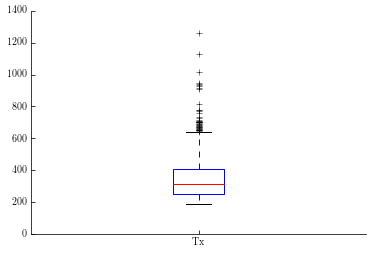

In [132]:
def measures_of_spread(durations):
    m = {}
    m['range'] = max(durations)-min(durations)
    m['min'], m['q1'], m['q2'], m['q3'], m['max'] = np.percentile(durations, [0,25,50,75,100])
    m['irq'] = m['q3'] - m['q1']
    m['var'] = np.var(durations)
    m['std'] = np.std(durations)
    m['mad'] = sm.robust.scale.mad(durations)

    return m

Tx_spreads = measures_of_spread(Txs)
pprint.pprint(Tx_spreads)

# MOVE TO DISTRIBUTIONS' ANALYSIS
plot = fig_setup()
plot.boxplot(Txs, labels=['Tx'])#, showmeans=True, showcaps=True)

plt.savefig('osg_cu_spread_box.pdf', dpi=600, bbox_inches='tight')

# - Mann-Whitney-Wilcoxon (MWW) RankSum test: determine 
#   whether two distributions are significantly 
#   different or not. Unlike the t-test, the RankSum 
#   test does not assume that the data are normally 
#   distributed. How do we interpret the difference?
x = np.linspace(min(Txs),max(Txs),len(Txs))
Txs_pdf = mlab.normpdf(x, u_mu, u_sigma)
z_stat, p_val = sps.ranksums(Txs, Txs_pdf)

## Skewness and Kurtosis

1.75849371287
4.73977533769
SkewtestResult(statistic=15.662231712452193, pvalue=2.7410735443502003e-55)
KurtosistestResult(statistic=10.332803105475254, pvalue=5.0075459397469875e-25)


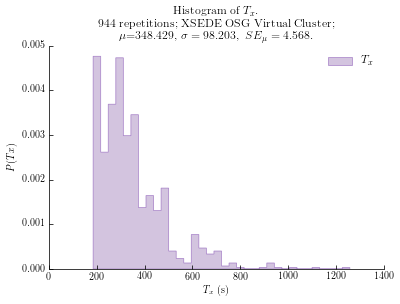

In [133]:
u_skew = sps.skew(Txs, bias=True)
u_skew_test = sps.skewtest(Txs)
u_kurt = sps.kurtosis(Txs)
u_kurt_test = sps.kurtosistest(Txs)

print u_skew
print u_kurt
print u_skew_test
print u_kurt_test

metric      = 'T_x'
description = 'Histogram of $%s$' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (u_mu, u_sigma, u_sem)
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, patches = ax.hist(Txs, bins='fd',
        normed=1,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[8], 
        color=tableau20[9],
        alpha=0.75)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
# ax.set_xlim(150, 700)
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('osg_cu_spread_hist.pdf', dpi=600, bbox_inches='tight')

In [134]:
# - Fit to the normal distribution: fit the empirical 
#   distribution to the normal for comparison purposes.    
(f_mu, f_sigma) = sps.norm.fit(Txs)

# sample_pdf = np.linspace(min(Txs),max(Txs), len(Txs))
sample_pdf = np.linspace(0,max(Txs), len(Txs))

2.04259892604e-12
0.00284425149226


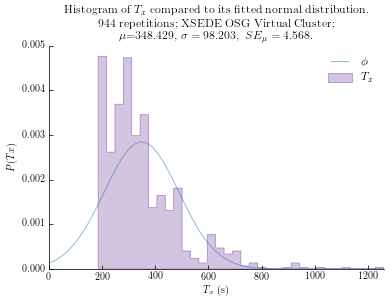

In [135]:
metric      = 'T_x'
description = 'Histogram of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (u_mu, u_sigma, u_sem)
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, p = ax.hist(Txs, bins='fd',
        normed=True,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[8], 
        color=tableau20[9],
        alpha=0.75)

pdf = mlab.normpdf(sample_pdf, f_mu, f_sigma)
print min(pdf)
print max(pdf)

ax.plot(sample_pdf, 
        pdf, 
        label="$\phi$", 
        color=tableau20[0],
        alpha=0.5)

# ax.fill_between(bins, 
#         sample_pdf,
#         color=tableau20[1],
#         alpha=0.25)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.set_xlim(min(sample_pdf), max(sample_pdf))
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('osg_cu_spread_pdf.pdf', dpi=600, bbox_inches='tight')

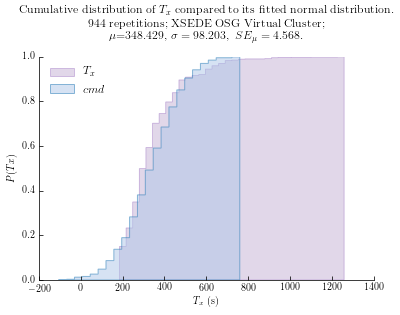

In [136]:
# Values for analytical pdf
sample_pdf = np.random.normal(loc=f_mu, scale=f_sigma, size=len(Txs))

metric      = 'T_x'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (u_mu, u_sigma, u_sem)
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

fig = plt.figure()
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

n, bins, p = ax.hist(Txs, 
        bins='fd',
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[8], 
        color=tableau20[9],
        alpha=0.5)

ax.hist(sample_pdf, 
        bins='fd', 
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$cmd$",
        edgecolor=tableau20[0], 
        color=tableau20[1], 
        alpha=0.5)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_cu_cumulative_hist.pdf', dpi=600, bbox_inches='tight')

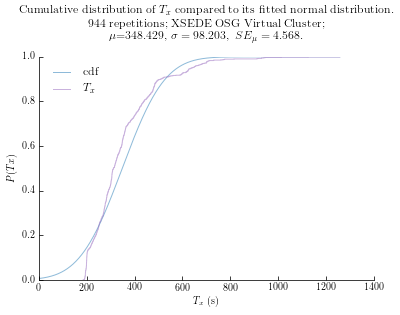

In [137]:
Txs_np = np.array(Txs)

# Cumulative samples
Txs_sum = np.cumsum(np.ones(Txs_np.shape))/len(Txs)

# Values for analytical cdf
sample_cdf = np.linspace(0,max(Txs), len(Txs))

metric      = 'T_x'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (u_mu, u_sigma, u_sem)
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

fig = plt.figure()
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

ax.plot(sample_cdf, 
        sps.norm.cdf(sample_cdf, f_mu, f_sigma), 
        label="cdf",
        color=tableau20[0],
        alpha=.5)

ax.step(Txs, 
        Txs_sum,
        label="$T_x$",
        where='post',
        color=tableau20[8],
        alpha=.5)
plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_cu_cumulative_plot.pdf', dpi=600, bbox_inches='tight')

In [138]:
s = sessions['rp.session.radical.mingtha.017033.0007']
print s.describe('relations', entities=['pilot.0000', 'unit'])
ids = s.filter(etype=['unit'], inplace=False).get()
for unit in ids:
    pprint.pprint(unit.uid)

TypeError: describe() got an unexpected keyword argument 'entities'